In [1]:
from __future__ import division

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

import astropy.units as u
from astropy.cosmology import z_at_value

from lenstools.simulations.fastpm import FastPMSnapshot 
from lenstools.simulations.raytracing import DensityPlane, PotentialPlane, RayTracer
from lenstools.image.convergence import ConvergenceMap

/usr/local/lib/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [2]:
#Read in the snapshot
snap_path = "/Users/andreapetri/Documents/Cosmology_software/LensTools/SimTest/Storage/Om0.290_Ol0.710/128b128/ic1/snapshots/lightconeresult"
snap = FastPMSnapshot.open(snap_path)
snap.getPositions()

<Quantity [[  1.27618767e+02,  5.04905879e-01,  1.27383766e+02],
           [  1.26530273e+02,  4.09351444e+00,  1.93040812e+00],
           [  3.39050293e-02,  3.97269797e+00,  3.23024702e+00],
           ..., 
           [  1.26884491e+02,  1.27305405e+02,  1.24556503e+02],
           [  1.26888199e+02,  1.27430794e+02,  1.25522659e+02],
           [  1.26898415e+02,  1.27643196e+02,  1.26618202e+02]] Mpc/h>

In [3]:
#Replace the z positions in the snapshot with the actual comoving distances for realistic integration
snap.positions[:,2] = snap.cosmology.comoving_distance(1./snap.aemit - 1).to(snap.positions.unit).astype(np.float32)

## Cut a thin lens from the FastPM snapshot

In [4]:
#Location and thickness of the lens
plane_center = 1000.*snap.Mpc_over_h
plane_thickness = 80.*snap.Mpc_over_h

plane_center,plane_thickness

(<Quantity 1000.0 Mpc/h>, <Quantity 80.0 Mpc/h>)

In [5]:
#Cut a two dimensional lens
density_2d,res,npart = snap.cutPlaneGaussianGrid(normal=2,center=plane_center,thickness=plane_thickness,plane_resolution=64,kind="density")
potential_2d,res,npart = snap.cutPlaneGaussianGrid(normal=2,center=plane_center,thickness=plane_thickness,plane_resolution=64,kind="potential")

In [6]:
#Plane shape
density_2d.shape

(64, 64)

In [7]:
#Build PotentialPlane and DensityPlane instances
density_2d = DensityPlane(density_2d,angle=snap.header["box_size"],comoving_distance=plane_center)
potential_2d = PotentialPlane(potential_2d.value,angle=snap.header["box_size"],comoving_distance=plane_center,unit=u.rad**2)

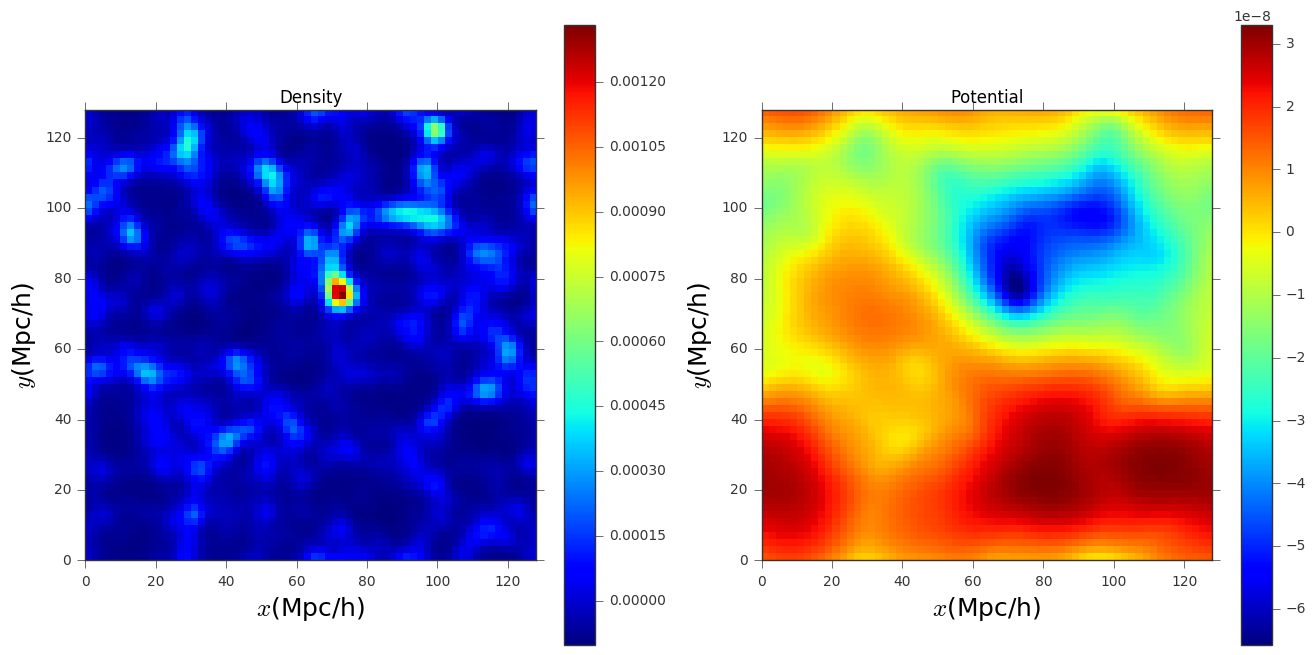

In [8]:
#Visualize
fig,ax = plt.subplots(1,2,figsize=(16,8))
density_2d.visualize(fig=fig,ax=ax[0],colorbar=True)
potential_2d.visualize(fig=fig,ax=ax[1],colorbar=True)

ax[0].set_title("Density")
ax[1].set_title("Potential")

## Ray tracing operations (Born approximation VS full raytracing)

In [9]:
#Integrate up to this redshift
z = 5.0
chi_max = snap.cosmology.comoving_distance(z)
chi_max

<Quantity 7624.921246364858 Mpc>

In [10]:
#Lens discretization
num_lenses = 40

thickness = chi_max / num_lenses
chi_start = thickness/2
chi_end = chi_max - thickness/2

#Lens centers
chi_centers = np.linspace(chi_start.value,chi_end.value,num_lenses)*chi_max.unit
chi_centers

<Quantity [   95.31151558,  285.93454674,  476.5575779 ,  667.18060906,
             857.80364022, 1048.42667138, 1239.04970253, 1429.67273369,
            1620.29576485, 1810.91879601, 2001.54182717, 2192.16485833,
            2382.78788949, 2573.41092065, 2764.03395181, 2954.65698297,
            3145.28001413, 3335.90304528, 3526.52607644, 3717.1491076 ,
            3907.77213876, 4098.39516992, 4289.01820108, 4479.64123224,
            4670.2642634 , 4860.88729456, 5051.51032572, 5242.13335688,
            5432.75638803, 5623.37941919, 5814.00245035, 6004.62548151,
            6195.24851267, 6385.87154383, 6576.49457499, 6767.11760615,
            6957.74063731, 7148.36366847, 7338.98669963, 7529.60973079] Mpc>

In [11]:
#Cut the lenses and add them to the raytracer
tracer = RayTracer()
for chi in chi_centers:
    zlens = z_at_value(snap.cosmology.comoving_distance,chi)
    d,r,n = snap.cutPlaneGaussianGrid(normal=2,center=chi,thickness=thickness,plane_resolution=256,kind="potential")
    lens = PotentialPlane(d.value,angle=snap.header["box_size"],comoving_distance=chi,redshift=zlens,cosmology=snap.cosmology,unit=u.rad**2)
    tracer.addLens(lens)

#Add a fudge lens at the end (needed by ODE solver implementation)
chi_fudge = chi_end + thickness
z_fudge = 1000.
tracer.addLens(PotentialPlane(np.zeros((256,256)),angle=snap.header["box_size"],redshift=z_fudge,comoving_distance=chi_fudge,cosmology=snap.cosmology,num_particles=None))

#Order lenses
tracer.reorderLenses()

In [13]:
#Field of view
fov = 1.3*u.deg
fov_resolution = 128

#Initial ray positions
b = np.linspace(0.,fov.value,fov_resolution)
pos = np.array(np.meshgrid(b,b))*fov.unit

In [14]:
#Born
conv_born = tracer.convergenceBorn(pos,z=z)

#Full raytracing
jacobian = tracer.shoot(pos,z=z,kind="jacobians")
conv_full = 1.0 - 0.5*(jacobian[0]+jacobian[3])

#Wrappers
conv_born = ConvergenceMap(conv_born,angle=fov)
conv_full = ConvergenceMap(conv_full,angle=fov)

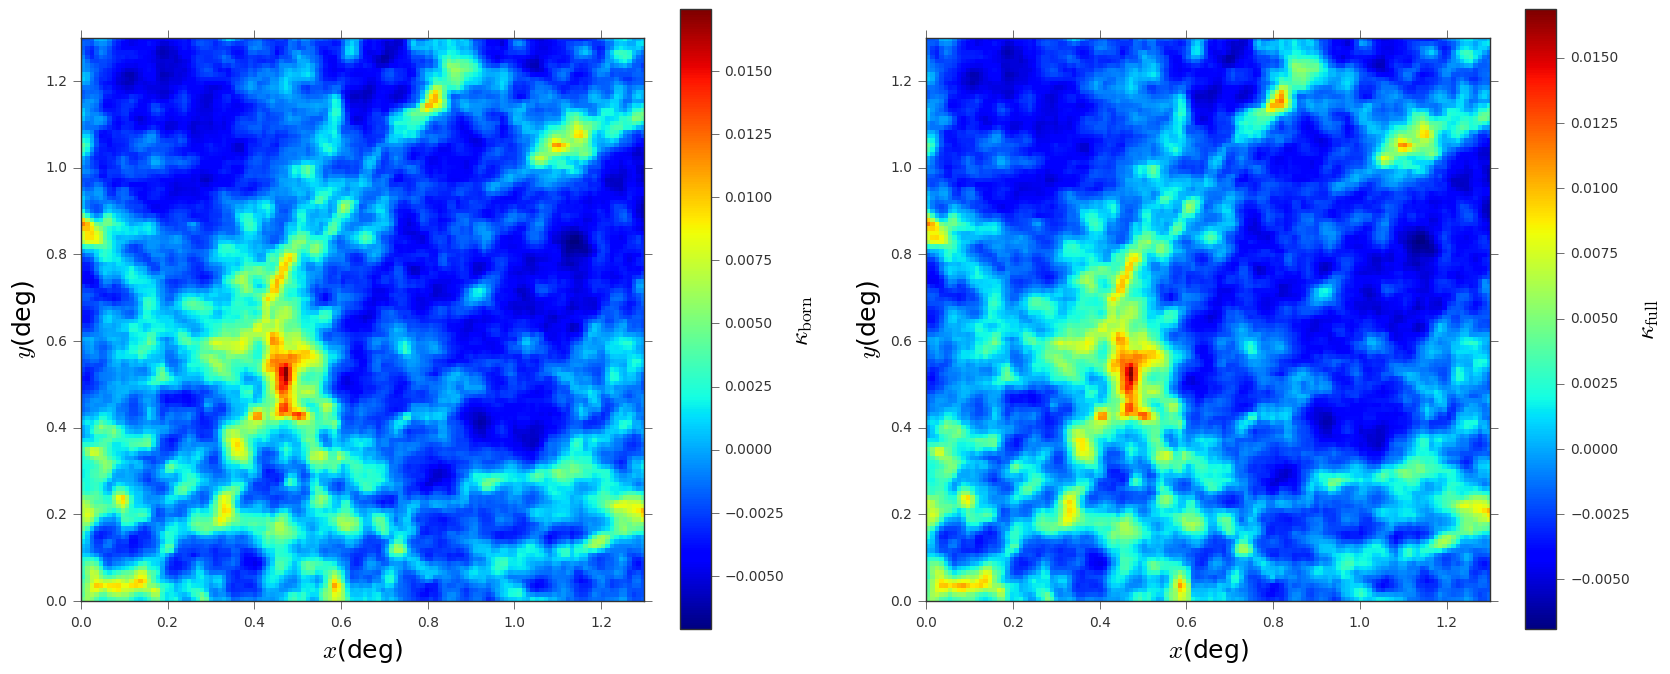

In [15]:
#Visualize and compare
fig,ax = plt.subplots(1,2,figsize=(20,8))
conv_born.visualize(fig=fig,ax=ax[0],colorbar=True,cbar_label=r"$\kappa_{\rm born}$")
conv_full.visualize(fig=fig,ax=ax[1],colorbar=True,cbar_label=r"$\kappa_{\rm full}$")

In [16]:
#Close snapshot
snap.close()